In [1]:
from zipfile import ZipFile
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
import mxnet.ndarray as F
import random


In [2]:
mx.random.seed(1)
random.seed(1)

data_ctx = mx.cpu()
model_ctx = mx.cpu()

In [3]:
class DataLoader(object):
    def __init__(self, min_batch_size=32):
        DIR = 'data/'
        self.min_batch_size=min_batch_size
        
    
    # Returns images and labels corresponding for training and testing. Default mode is train. 
    # For retrieving test data pass mode as 'test' in function call.
    def load_data(self, mode = 'train'):
        label_filename = mode + '_labels'
        image_filename = mode + '_images'
        label_zip = 'data/' + label_filename + '.zip'
        image_zip = 'data/' + image_filename + '.zip'
        with ZipFile(label_zip, 'r') as lblzip:
            labels = np.frombuffer(lblzip.read(label_filename), dtype=np.uint8, offset=8)
        with ZipFile(image_zip, 'r') as imgzip:
            images = np.frombuffer(imgzip.read(image_filename), dtype=np.uint8, offset=16).reshape(len(labels), 784)
        return images, labels

In [4]:
data_obj = DataLoader()
X_train, y_train = data_obj.load_data(mode='train')
X_train = X_train.astype('float32')
y_train = y_train
X_test, y_test = data_obj.load_data(mode='test')
X_test = X_test.astype('float32')
num_inputs = 784
num_outputs = 10
num_examples = X_train.shape[0]

In [5]:
print(X_train.shape)
print(y_train.shape)

(60000, 784)
(60000,)


In [6]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(1024, activation="relu"))
    net.add(gluon.nn.Dense(512, activation="relu"))
    net.add(gluon.nn.Dense(256, activation="relu"))
    net.add(gluon.nn.Dense(10))

In [7]:
net.collect_params()

sequential0_ (
  Parameter sequential0_dense0_weight (shape=(1024, 0), dtype=float32)
  Parameter sequential0_dense0_bias (shape=(1024,), dtype=float32)
  Parameter sequential0_dense1_weight (shape=(512, 0), dtype=float32)
  Parameter sequential0_dense1_bias (shape=(512,), dtype=float32)
  Parameter sequential0_dense2_weight (shape=(256, 0), dtype=float32)
  Parameter sequential0_dense2_bias (shape=(256,), dtype=float32)
  Parameter sequential0_dense3_weight (shape=(10, 0), dtype=float32)
  Parameter sequential0_dense3_bias (shape=(10,), dtype=float32)
)

In [8]:
net.collect_params().initialize(mx.initializer.Uniform(0.01), ctx=model_ctx)


In [9]:
type(net.collect_params())

mxnet.gluon.parameter.ParameterDict

In [10]:
square_loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [11]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0001})


In [12]:
batch_size = 32
train_data = gluon.data.DataLoader(
    gluon.data.dataset.ArrayDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

test_data = gluon.data.DataLoader(
    gluon.data.dataset.ArrayDataset(X_test, y_test), batch_size=batch_size, shuffle=True)

In [13]:
epochs = 10
num_batches = num_examples / batch_size
print(num_batches)

1875.0


In [14]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1, 784))
        label = label.as_in_context(model_ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [44]:




def train_loop(epochs):
    
    loss_ = []
    
    period = 10
    for e in range(2):
        cumulative_loss = 0
        total_loss = []
        sum = 0
        for i, (data, label) in enumerate(train_data):
            data = data.as_in_context(model_ctx).reshape(-1,784)
            label = label.as_in_context(model_ctx)
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
                
            loss.backward()
            trainer.step(batch_size)
            cumulative_loss += nd.mean(loss).asscalar()
            
            
            if i * batch_size % period == 0:
                total_loss.append(np.mean(nd.mean(loss).asnumpy()))
                sum = sum+1
                
        loss_.append(cumulative_loss/sum)
            
        test_accuracy = evaluate_accuracy(test_data, net)
        train_accuracy = evaluate_accuracy(train_data, net)
        
        test_accuracy1.append(test_accuracy)
        train_accuracy1.append(train_accuracy)
        
        print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, cumulative_loss/num_examples,
                                                                 train_accuracy, test_accuracy))
        #print("Epoch %s, loss: %.4f" % (e, cumulative_loss / num_examples))
        
    return loss_
    

    

In [45]:
loss_ = train_loop(epochs)

Epoch 0. Loss: 0.012432920054097971, Train_acc 0.8634, Test_acc 0.8453
Epoch 1. Loss: 0.012296646420471371, Train_acc 0.8630333333333333, Test_acc 0.8471


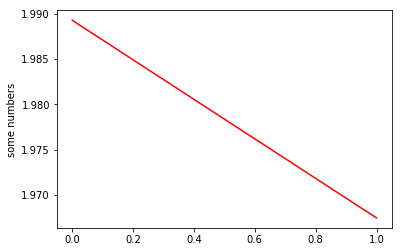

In [51]:
import matplotlib.pyplot as plt

plt.plot(np.arange(2), loss_, 'r-')
plt.ylabel('some numbers')
plt.show()

In [46]:
loss_

[1.9892672086556753, 1.9674634272754192]

In [52]:
file_name = "net.params"
net.save_parameters(file_name)